# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [30]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   con         1206 non-null   int64 
 1   wis         1206 non-null   int64 
 2   perception  1206 non-null   int64 
 3   fortitude   1206 non-null   int64 
 4   level       1206 non-null   int64 
 5   book        1206 non-null   object
 6   int         1206 non-null   int64 
 7   focus       1206 non-null   int32 
 8   cha         1206 non-null   int64 
 9   hp          1206 non-null   int64 
 10  str         1206 non-null   int64 
 11  ac          1206 non-null   int64 
 12  dex         1206 non-null   int64 
 13  will        1206 non-null   int64 
 14  reflex      1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [32]:
df.head()

,con,wis,perception,fortitude,level,book,int,focus,cha,hp,str,ac,dex,will,reflex
0,5,2,20,22,10,Pathfinder Bestiary,1,1,1,215,7,29,2,17,19
1,5,2,16,21,10,Pathfinder Bestiary,-4,0,1,220,9,28,0,16,14
2,6,3,17,20,8,Pathfinder Bestiary,-4,0,-2,175,7,25,3,15,17
3,5,5,30,30,17,Pathfinder Bestiary,6,1,6,315,7,41,4,32,29
4,1,1,6,6,1,Pathfinder Bestiary,-1,1,1,20,-5,16,3,4,10


###### Level

In [33]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [34]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [35]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


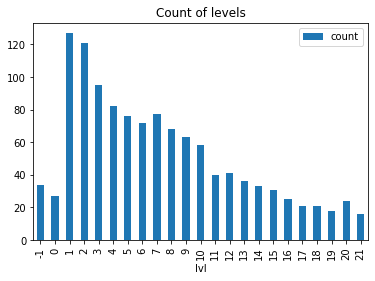

In [36]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [37]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [38]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [39]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [40]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [41]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [42]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.36


In [44]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [45]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [46]:
from training.results import plot_mae_by_level

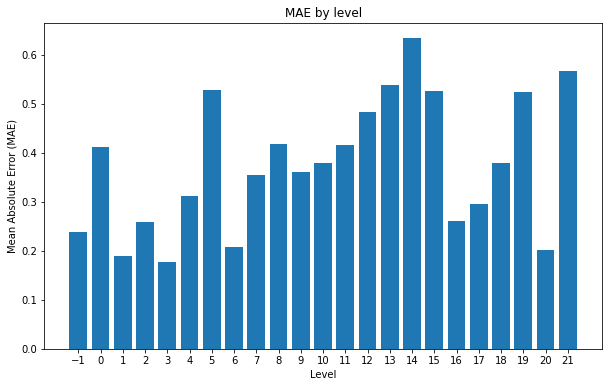

In [47]:
plot_mae_by_level(y_test, y_pred_test)

In [48]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



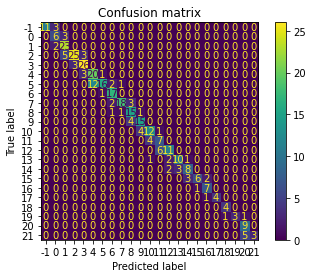

In [49]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [50]:
from training.results import assess_regression_model

In [51]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 13:57:49,198] A new study created in memory with name: no-name-abc85c5a-c14a-4da1-a7bf-d57fa53906b8
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.178763 + 0.0309869
[200]	cv_agg's l2: 0.177233 + 0.0307626


feature_fraction, val_score: 0.176561:  14%|######4                                      | 1/7 [00:02<00:17,  2.95s/it]

Early stopping, best iteration is:
[170]	cv_agg's l2: 0.176561 + 0.0304913
[100]	cv_agg's l2: 0.174425 + 0.0308807
[200]	cv_agg's l2: 0.170448 + 0.0287735
[300]	cv_agg's l2: 0.171289 + 0.0289134


feature_fraction, val_score: 0.170161:  29%|############8                                | 2/7 [00:05<00:14,  2.96s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.170161 + 0.0287902
[100]	cv_agg's l2: 0.173714 + 0.0308209
[200]	cv_agg's l2: 0.171089 + 0.029611
[300]	cv_agg's l2: 0.171043 + 0.0289592


feature_fraction, val_score: 0.170161:  43%|###################2                         | 3/7 [00:09<00:12,  3.04s/it]

Early stopping, best iteration is:
[251]	cv_agg's l2: 0.170161 + 0.0287902
[100]	cv_agg's l2: 0.16764 + 0.026502
[200]	cv_agg's l2: 0.165595 + 0.0254371
[300]	cv_agg's l2: 0.166117 + 0.0254648
Early stopping, best iteration is:
[219]	cv_agg's l2: 0.165189 + 0.0254108


feature_fraction, val_score: 0.165189:  57%|#########################7                   | 4/7 [00:12<00:09,  3.05s/it]

[100]	cv_agg's l2: 0.18941 + 0.0383339
[200]	cv_agg's l2: 0.186187 + 0.036368


feature_fraction, val_score: 0.165189:  57%|#########################7                   | 4/7 [00:15<00:09,  3.05s/it]

[300]	cv_agg's l2: 0.185644 + 0.0359688
Early stopping, best iteration is:
[219]	cv_agg's l2: 0.165189 + 0.0254108


feature_fraction, val_score: 0.165189:  71%|################################1            | 5/7 [00:15<00:06,  3.06s/it]

[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


feature_fraction, val_score: 0.161600:  86%|######################################5      | 6/7 [00:17<00:02,  2.76s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.179989 + 0.0291132
[200]	cv_agg's l2: 0.177268 + 0.0284709


feature_fraction, val_score: 0.161600: 100%|#############################################| 7/7 [00:19<00:00,  2.81s/it]


Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736


num_leaves, val_score: 0.161600:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:   5%|##5                                               | 1/20 [00:02<00:38,  2.05s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  10%|#####                                             | 2/20 [00:04<00:40,  2.23s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  15%|#######5                                          | 3/20 [00:06<00:39,  2.33s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.247453 + 0.0163546
[200]	cv_agg's l2: 0.216682 + 0.0151836


num_leaves, val_score: 0.161600:  20%|##########                                        | 4/20 [00:07<00:25,  1.61s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  25%|############5                                     | 5/20 [00:09<00:27,  1.80s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  30%|###############                                   | 6/20 [00:11<00:27,  1.98s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  35%|#################5                                | 7/20 [00:14<00:27,  2.13s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  40%|####################                              | 8/20 [00:16<00:27,  2.26s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  45%|######################5                           | 9/20 [00:19<00:25,  2.30s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  50%|########################5                        | 10/20 [00:21<00:22,  2.27s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  55%|##########################9                      | 11/20 [00:23<00:20,  2.25s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  60%|#############################4                   | 12/20 [00:25<00:17,  2.22s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  65%|###############################8                 | 13/20 [00:28<00:16,  2.36s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.354908 + 0.0587264
[200]	cv_agg's l2: 0.31512 + 0.0528942


num_leaves, val_score: 0.161600:  70%|##################################3              | 14/20 [00:28<00:10,  1.79s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  75%|####################################7            | 15/20 [00:31<00:09,  1.98s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  80%|#######################################2         | 16/20 [00:33<00:08,  2.04s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  85%|#########################################6       | 17/20 [00:35<00:06,  2.09s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  90%|############################################1    | 18/20 [00:37<00:04,  2.07s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600:  95%|##############################################5  | 19/20 [00:39<00:02,  2.07s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.165 + 0.0209332
[200]	cv_agg's l2: 0.163423 + 0.0211548


num_leaves, val_score: 0.161600: 100%|#################################################| 20/20 [00:42<00:00,  2.10s/it]


Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736


bagging, val_score: 0.161600:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.177048 + 0.0248358
[200]	cv_agg's l2: 0.1717 + 0.0209544


bagging, val_score: 0.161600:  10%|#####3                                               | 1/10 [00:01<00:17,  1.90s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.225864 + 0.0189661
[200]	cv_agg's l2: 0.207087 + 0.0197601


bagging, val_score: 0.161600:  20%|##########6                                          | 2/10 [00:02<00:11,  1.39s/it]

Early stopping, best iteration is:
[155]	cv_agg's l2: 0.1616 + 0.0210736
[100]	cv_agg's l2: 0.162576 + 0.0210527
[200]	cv_agg's l2: 0.158506 + 0.0195024
[300]	cv_agg's l2: 0.158449 + 0.0188568


bagging, val_score: 0.158249:  30%|###############9                                     | 3/10 [00:05<00:13,  1.91s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.161569 + 0.0220725
[200]	cv_agg's l2: 0.158926 + 0.0224023
[300]	cv_agg's l2: 0.160649 + 0.0226924


bagging, val_score: 0.158249:  40%|#####################2                               | 4/10 [00:08<00:13,  2.20s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.162207 + 0.0222409
[200]	cv_agg's l2: 0.159338 + 0.0222769
[300]	cv_agg's l2: 0.159961 + 0.0226725


bagging, val_score: 0.158249:  50%|##########################5                          | 5/10 [00:10<00:11,  2.36s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.160699 + 0.0192839
[200]	cv_agg's l2: 0.160614 + 0.0189042


bagging, val_score: 0.158249:  60%|###############################8                     | 6/10 [00:14<00:11,  2.91s/it]

[300]	cv_agg's l2: 0.161523 + 0.0182515
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.163916 + 0.0206542
[200]	cv_agg's l2: 0.163139 + 0.0198974


bagging, val_score: 0.158249:  70%|#####################################                | 7/10 [00:16<00:07,  2.55s/it]

[300]	cv_agg's l2: 0.165211 + 0.0201398
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.164567 + 0.0208642
[200]	cv_agg's l2: 0.165623 + 0.0226847


bagging, val_score: 0.158249:  80%|##########################################4          | 8/10 [00:18<00:04,  2.33s/it]

[300]	cv_agg's l2: 0.166484 + 0.0226283
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.166069 + 0.0196223
[200]	cv_agg's l2: 0.164167 + 0.0216404


bagging, val_score: 0.158249:  90%|###############################################7     | 9/10 [00:19<00:02,  2.09s/it]

[300]	cv_agg's l2: 0.165202 + 0.0219367
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.158249 + 0.019102
[100]	cv_agg's l2: 0.159579 + 0.0229813
[200]	cv_agg's l2: 0.156999 + 0.0210609


bagging, val_score: 0.156666: 100%|####################################################| 10/10 [00:21<00:00,  2.13s/it]


Early stopping, best iteration is:
[171]	cv_agg's l2: 0.156666 + 0.0205646


feature_fraction_stage2, val_score: 0.156666:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165642 + 0.0313727
[200]	cv_agg's l2: 0.164447 + 0.0310573


feature_fraction_stage2, val_score: 0.156666:  33%|############6                         | 1/3 [00:01<00:03,  1.59s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.156666 + 0.0205646
[100]	cv_agg's l2: 0.159579 + 0.0229813
[200]	cv_agg's l2: 0.156999 + 0.0210609


feature_fraction_stage2, val_score: 0.156666:  67%|#########################3            | 2/3 [00:03<00:01,  1.91s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.156666 + 0.0205646
[100]	cv_agg's l2: 0.165642 + 0.0313727
[200]	cv_agg's l2: 0.164447 + 0.0310573


feature_fraction_stage2, val_score: 0.156666: 100%|######################################| 3/3 [00:05<00:00,  1.94s/it]


Early stopping, best iteration is:
[171]	cv_agg's l2: 0.156666 + 0.0205646


regularization_factors, val_score: 0.156666:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.161083 + 0.0212015
[200]	cv_agg's l2: 0.157171 + 0.0199148
[300]	cv_agg's l2: 0.157034 + 0.0199115


regularization_factors, val_score: 0.156613:   5%|#9                                    | 1/20 [00:03<00:57,  3.00s/it]

Early stopping, best iteration is:
[279]	cv_agg's l2: 0.156613 + 0.0200031
[100]	cv_agg's l2: 0.160302 + 0.0208357
[200]	cv_agg's l2: 0.15686 + 0.0198359


regularization_factors, val_score: 0.156240:  10%|###8                                  | 2/20 [00:05<00:46,  2.59s/it]

Early stopping, best iteration is:
[168]	cv_agg's l2: 0.15624 + 0.0187993
[100]	cv_agg's l2: 0.162041 + 0.0214612
[200]	cv_agg's l2: 0.15831 + 0.0205323


regularization_factors, val_score: 0.156240:  15%|#####7                                | 3/20 [00:07<00:40,  2.36s/it]

Early stopping, best iteration is:
[168]	cv_agg's l2: 0.15624 + 0.0187993
[100]	cv_agg's l2: 0.163138 + 0.0188784
[200]	cv_agg's l2: 0.159866 + 0.0173865


regularization_factors, val_score: 0.156240:  20%|#######6                              | 4/20 [00:09<00:37,  2.34s/it]

Early stopping, best iteration is:
[168]	cv_agg's l2: 0.15624 + 0.0187993
[100]	cv_agg's l2: 0.164413 + 0.0201876
[200]	cv_agg's l2: 0.160458 + 0.0174228


regularization_factors, val_score: 0.156240:  25%|#########5                            | 5/20 [00:12<00:35,  2.34s/it]

Early stopping, best iteration is:
[168]	cv_agg's l2: 0.15624 + 0.0187993
[100]	cv_agg's l2: 0.158994 + 0.0190182
[200]	cv_agg's l2: 0.156031 + 0.0177293


regularization_factors, val_score: 0.155116:  30%|###########4                          | 6/20 [00:14<00:31,  2.25s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.160016 + 0.022756
[200]	cv_agg's l2: 0.155957 + 0.020695


regularization_factors, val_score: 0.155116:  35%|#############3                        | 7/20 [00:16<00:28,  2.18s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.161035 + 0.0234727
[200]	cv_agg's l2: 0.156788 + 0.0216009


regularization_factors, val_score: 0.155116:  40%|###############2                      | 8/20 [00:18<00:25,  2.11s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.159579 + 0.0229813
[200]	cv_agg's l2: 0.156699 + 0.0209257


regularization_factors, val_score: 0.155116:  45%|#################1                    | 9/20 [00:20<00:22,  2.06s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.173927 + 0.0222717
[200]	cv_agg's l2: 0.16629 + 0.0220224


regularization_factors, val_score: 0.155116:  50%|##################5                  | 10/20 [00:22<00:20,  2.04s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.160831 + 0.0233426
[200]	cv_agg's l2: 0.157007 + 0.021962


regularization_factors, val_score: 0.155116:  55%|####################3                | 11/20 [00:24<00:18,  2.06s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.16 + 0.0227586
[200]	cv_agg's l2: 0.156608 + 0.0204776


regularization_factors, val_score: 0.155116:  60%|######################2              | 12/20 [00:26<00:16,  2.05s/it]

Early stopping, best iteration is:
[142]	cv_agg's l2: 0.155116 + 0.0179764
[100]	cv_agg's l2: 0.158463 + 0.0242337
[200]	cv_agg's l2: 0.155001 + 0.0208999


regularization_factors, val_score: 0.154820:  65%|########################             | 13/20 [00:28<00:14,  2.11s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.15482 + 0.0206737
[100]	cv_agg's l2: 0.157285 + 0.0219736
[200]	cv_agg's l2: 0.154216 + 0.0205728


regularization_factors, val_score: 0.153322:  70%|#########################9           | 14/20 [00:30<00:12,  2.16s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638
[100]	cv_agg's l2: 0.161084 + 0.0204298
[200]	cv_agg's l2: 0.157614 + 0.0204911


regularization_factors, val_score: 0.153322:  75%|###########################7         | 15/20 [00:32<00:10,  2.15s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638
[100]	cv_agg's l2: 0.158166 + 0.023688
[200]	cv_agg's l2: 0.155983 + 0.0224038


regularization_factors, val_score: 0.153322:  80%|#############################6       | 16/20 [00:35<00:08,  2.16s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638
[100]	cv_agg's l2: 0.157449 + 0.0238412
[200]	cv_agg's l2: 0.154353 + 0.0212022


regularization_factors, val_score: 0.153322:  85%|###############################4     | 17/20 [00:37<00:06,  2.14s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638
[100]	cv_agg's l2: 0.160629 + 0.0227092
[200]	cv_agg's l2: 0.156474 + 0.0203211


regularization_factors, val_score: 0.153322:  90%|#################################3   | 18/20 [00:39<00:04,  2.16s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638
[100]	cv_agg's l2: 0.161483 + 0.0230783
[200]	cv_agg's l2: 0.157404 + 0.021283


regularization_factors, val_score: 0.153322:  95%|###################################1 | 19/20 [00:41<00:02,  2.16s/it]

Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638
[100]	cv_agg's l2: 0.159705 + 0.0210984
[200]	cv_agg's l2: 0.156634 + 0.0193296


regularization_factors, val_score: 0.153322: 100%|#####################################| 20/20 [00:43<00:00,  2.18s/it]


Early stopping, best iteration is:
[171]	cv_agg's l2: 0.153322 + 0.0203638


min_data_in_leaf, val_score: 0.153322:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.150375 + 0.0227675
[200]	cv_agg's l2: 0.149205 + 0.0227508


min_data_in_leaf, val_score: 0.149191:  20%|#########                                    | 1/5 [00:03<00:12,  3.14s/it]

Early stopping, best iteration is:
[179]	cv_agg's l2: 0.149191 + 0.0225111
[100]	cv_agg's l2: 0.813146 + 0.127842
[200]	cv_agg's l2: 0.780174 + 0.139509


min_data_in_leaf, val_score: 0.149191:  40%|##################                           | 2/5 [00:03<00:05,  1.77s/it]

Early stopping, best iteration is:
[179]	cv_agg's l2: 0.149191 + 0.0225111
[100]	cv_agg's l2: 0.147078 + 0.0268049
[200]	cv_agg's l2: 0.146269 + 0.0268461


min_data_in_leaf, val_score: 0.145941:  60%|###########################                  | 3/5 [00:07<00:04,  2.44s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.145941 + 0.0268
[100]	cv_agg's l2: 0.173471 + 0.0216301
[200]	cv_agg's l2: 0.168793 + 0.0180197


min_data_in_leaf, val_score: 0.145941:  80%|####################################         | 4/5 [00:09<00:02,  2.29s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.145941 + 0.0268
[100]	cv_agg's l2: 0.249512 + 0.0155629
[200]	cv_agg's l2: 0.228665 + 0.018686


min_data_in_leaf, val_score: 0.145941: 100%|#############################################| 5/5 [00:10<00:00,  2.11s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.145941 + 0.0268


In [52]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14594124845945636
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.3553203931047317e-06
    lambda_l2: 0.04607120158815861
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.9412192276451357
    bagging_freq: 1
    min_child_samples: 10


In [53]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [54]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.44
MSE test: 0.19
MAE test: 0.31



In [55]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

###### MAE by level

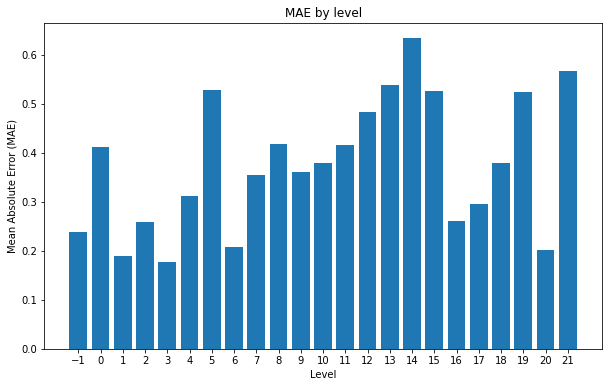

In [56]:
plot_mae_by_level(y_test, y_pred_test)

In [57]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.19
RMSE: 0.44

Round type: round
MSE: 0.22
RMSE: 0.47

Round type: 0.33
MSE: 0.23
RMSE: 0.48

Round type: 0.45
MSE: 0.21
RMSE: 0.46



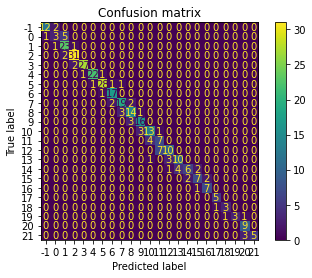

In [58]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [59]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.148111	valid_0's l1: 0.267273


In [60]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.27


In [62]:
results.loc[2] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

###### MAE by level

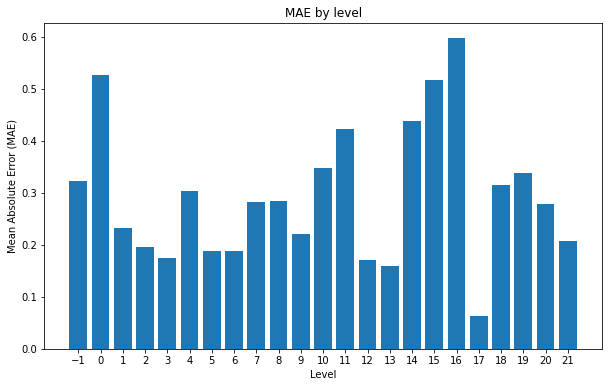

In [63]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [64]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



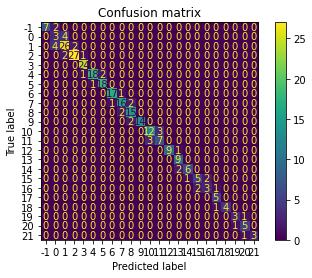

In [65]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [66]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 14:00:39,152] A new study created in memory with name: no-name-0b51f6d4-4181-4101-bc0a-6e64e1cf7880
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.193746 + 0.0445184
[200]	cv_agg's l2: 0.189689 + 0.0411654


feature_fraction, val_score: 0.189040:  14%|######4                                      | 1/7 [00:02<00:15,  2.64s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.18904 + 0.0411858
[100]	cv_agg's l2: 0.18579 + 0.058983


feature_fraction, val_score: 0.185652:  29%|############8                                | 2/7 [00:04<00:10,  2.10s/it]

Early stopping, best iteration is:
[98]	cv_agg's l2: 0.185652 + 0.0586453
[100]	cv_agg's l2: 0.176155 + 0.0475409
[200]	cv_agg's l2: 0.174777 + 0.0433107


feature_fraction, val_score: 0.174514:  43%|###################2                         | 3/7 [00:07<00:09,  2.37s/it]

[300]	cv_agg's l2: 0.175545 + 0.0426359
Early stopping, best iteration is:
[213]	cv_agg's l2: 0.174514 + 0.0427682
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


feature_fraction, val_score: 0.164789:  57%|#########################7                   | 4/7 [00:09<00:06,  2.28s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.174766 + 0.0519624
[200]	cv_agg's l2: 0.174493 + 0.0510939


feature_fraction, val_score: 0.164789:  71%|################################1            | 5/7 [00:11<00:04,  2.29s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.184289 + 0.0450428
[200]	cv_agg's l2: 0.182447 + 0.0433615


feature_fraction, val_score: 0.164789:  86%|######################################5      | 6/7 [00:13<00:02,  2.33s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.191562 + 0.0499245
[200]	cv_agg's l2: 0.188012 + 0.0458458


feature_fraction, val_score: 0.164789: 100%|#############################################| 7/7 [00:16<00:00,  2.35s/it]


Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064


num_leaves, val_score: 0.164789:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:   5%|##5                                               | 1/20 [00:02<00:41,  2.18s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  10%|#####                                             | 2/20 [00:04<00:40,  2.24s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  15%|#######5                                          | 3/20 [00:06<00:37,  2.20s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.169047 + 0.0188749
[200]	cv_agg's l2: 0.168104 + 0.0179058


num_leaves, val_score: 0.164789:  20%|##########                                        | 4/20 [00:08<00:31,  1.97s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  25%|############5                                     | 5/20 [00:10<00:31,  2.07s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  30%|###############                                   | 6/20 [00:12<00:30,  2.14s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  35%|#################5                                | 7/20 [00:14<00:28,  2.17s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  40%|####################                              | 8/20 [00:17<00:26,  2.18s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  45%|######################5                           | 9/20 [00:19<00:24,  2.20s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  50%|########################5                        | 10/20 [00:21<00:21,  2.20s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.169047 + 0.0188749
[200]	cv_agg's l2: 0.168104 + 0.0179058


num_leaves, val_score: 0.164789:  55%|##########################9                      | 11/20 [00:23<00:18,  2.01s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  60%|#############################4                   | 12/20 [00:25<00:16,  2.08s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  65%|###############################8                 | 13/20 [00:27<00:15,  2.16s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  70%|##################################3              | 14/20 [00:29<00:12,  2.16s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  75%|####################################7            | 15/20 [00:32<00:10,  2.18s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  80%|#######################################2         | 16/20 [00:34<00:08,  2.17s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  85%|#########################################6       | 17/20 [00:36<00:06,  2.20s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  90%|############################################1    | 18/20 [00:38<00:04,  2.22s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789:  95%|##############################################5  | 19/20 [00:41<00:02,  2.21s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165895 + 0.0225784
[200]	cv_agg's l2: 0.165765 + 0.0218917


num_leaves, val_score: 0.164789: 100%|#################################################| 20/20 [00:43<00:00,  2.16s/it]


Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064


bagging, val_score: 0.164789:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.211969 + 0.0261565
[200]	cv_agg's l2: 0.205105 + 0.0223455


bagging, val_score: 0.164789:  10%|#####3                                               | 1/10 [00:01<00:11,  1.23s/it]

Early stopping, best iteration is:
[153]	cv_agg's l2: 0.164789 + 0.0226064
[100]	cv_agg's l2: 0.165065 + 0.0232895
[200]	cv_agg's l2: 0.16179 + 0.0213701


bagging, val_score: 0.161363:  20%|##########6                                          | 2/10 [00:03<00:15,  1.99s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.166043 + 0.0243238
[200]	cv_agg's l2: 0.164484 + 0.0212817


bagging, val_score: 0.161363:  30%|###############9                                     | 3/10 [00:06<00:15,  2.25s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.166029 + 0.0229835
[200]	cv_agg's l2: 0.165411 + 0.0236962


bagging, val_score: 0.161363:  40%|#####################2                               | 4/10 [00:08<00:14,  2.36s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.165024 + 0.0254141
[200]	cv_agg's l2: 0.161961 + 0.0226817


bagging, val_score: 0.161363:  50%|##########################5                          | 5/10 [00:11<00:12,  2.44s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.166972 + 0.0249813
[200]	cv_agg's l2: 0.16393 + 0.023701


bagging, val_score: 0.161363:  60%|###############################8                     | 6/10 [00:13<00:09,  2.48s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.168991 + 0.0281112
[200]	cv_agg's l2: 0.167375 + 0.0273307


bagging, val_score: 0.161363:  70%|#####################################                | 7/10 [00:16<00:07,  2.56s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.168143 + 0.0220749
[200]	cv_agg's l2: 0.164989 + 0.020663


bagging, val_score: 0.161363:  80%|##########################################4          | 8/10 [00:19<00:05,  2.59s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.167487 + 0.0243641
[200]	cv_agg's l2: 0.164258 + 0.0223329


bagging, val_score: 0.161363:  90%|###############################################7     | 9/10 [00:21<00:02,  2.55s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.166611 + 0.0217404
[200]	cv_agg's l2: 0.162945 + 0.0175755


bagging, val_score: 0.161363: 100%|####################################################| 10/10 [00:24<00:00,  2.41s/it]


Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322


feature_fraction_stage2, val_score: 0.161363:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.163652 + 0.0367363
[200]	cv_agg's l2: 0.164907 + 0.0333012


feature_fraction_stage2, val_score: 0.161363:  33%|############6                         | 1/3 [00:02<00:04,  2.43s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.165065 + 0.0232895
[200]	cv_agg's l2: 0.16179 + 0.0213701


feature_fraction_stage2, val_score: 0.161363:  67%|#########################3            | 2/3 [00:04<00:02,  2.43s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322
[100]	cv_agg's l2: 0.163652 + 0.0367363
[200]	cv_agg's l2: 0.164907 + 0.0333012


feature_fraction_stage2, val_score: 0.161363: 100%|######################################| 3/3 [00:07<00:00,  2.44s/it]


Early stopping, best iteration is:
[197]	cv_agg's l2: 0.161363 + 0.0214322


regularization_factors, val_score: 0.161363:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164861 + 0.0247688
[200]	cv_agg's l2: 0.160019 + 0.0215908


regularization_factors, val_score: 0.159951:   5%|#9                                    | 1/20 [00:02<00:48,  2.53s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.166092 + 0.0247273
[200]	cv_agg's l2: 0.162987 + 0.0220837


regularization_factors, val_score: 0.159951:  10%|###8                                  | 2/20 [00:05<00:44,  2.49s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.166795 + 0.0243073
[200]	cv_agg's l2: 0.162844 + 0.0230857


regularization_factors, val_score: 0.159951:  15%|#####7                                | 3/20 [00:07<00:42,  2.51s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164446 + 0.0248143
[200]	cv_agg's l2: 0.160109 + 0.0215722


regularization_factors, val_score: 0.159951:  20%|#######6                              | 4/20 [00:09<00:39,  2.47s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.165489 + 0.0244914
[200]	cv_agg's l2: 0.162901 + 0.0209954


regularization_factors, val_score: 0.159951:  25%|#########5                            | 5/20 [00:12<00:36,  2.46s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.170757 + 0.0251694
[200]	cv_agg's l2: 0.164795 + 0.0207588


regularization_factors, val_score: 0.159951:  30%|###########4                          | 6/20 [00:14<00:33,  2.42s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.168872 + 0.0275928
[200]	cv_agg's l2: 0.164499 + 0.0256104


regularization_factors, val_score: 0.159951:  35%|#############3                        | 7/20 [00:16<00:27,  2.13s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164492 + 0.0234046
[200]	cv_agg's l2: 0.160713 + 0.0218319


regularization_factors, val_score: 0.159951:  40%|###############2                      | 8/20 [00:18<00:27,  2.31s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.16443 + 0.023434
[200]	cv_agg's l2: 0.161303 + 0.0220396


regularization_factors, val_score: 0.159951:  45%|#################1                    | 9/20 [00:21<00:25,  2.35s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164371 + 0.0237478
[200]	cv_agg's l2: 0.161451 + 0.0223606


regularization_factors, val_score: 0.159951:  50%|##################5                  | 10/20 [00:23<00:24,  2.41s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164106 + 0.0238338
[200]	cv_agg's l2: 0.160293 + 0.0223854


regularization_factors, val_score: 0.159951:  55%|####################3                | 11/20 [00:26<00:22,  2.48s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164371 + 0.0237478
[200]	cv_agg's l2: 0.161451 + 0.0223606


regularization_factors, val_score: 0.159951:  60%|######################2              | 12/20 [00:28<00:19,  2.46s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164043 + 0.0238617
[200]	cv_agg's l2: 0.160502 + 0.0228728


regularization_factors, val_score: 0.159951:  65%|########################             | 13/20 [00:31<00:18,  2.59s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164106 + 0.0238338
[200]	cv_agg's l2: 0.160293 + 0.0223854


regularization_factors, val_score: 0.159951:  70%|#########################9           | 14/20 [00:34<00:15,  2.56s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.165432 + 0.0244945
[200]	cv_agg's l2: 0.161964 + 0.0219411


regularization_factors, val_score: 0.159951:  75%|###########################7         | 15/20 [00:36<00:12,  2.54s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.165794 + 0.0243753
[200]	cv_agg's l2: 0.162085 + 0.0207327


regularization_factors, val_score: 0.159951:  80%|#############################6       | 16/20 [00:39<00:10,  2.52s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164603 + 0.0236186
[200]	cv_agg's l2: 0.162246 + 0.0216099


regularization_factors, val_score: 0.159951:  85%|###############################4     | 17/20 [00:41<00:07,  2.50s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.166611 + 0.0252488
[200]	cv_agg's l2: 0.162815 + 0.0229565


regularization_factors, val_score: 0.159951:  90%|#################################3   | 18/20 [00:44<00:05,  2.50s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.164939 + 0.0233321
[200]	cv_agg's l2: 0.161506 + 0.0214333


regularization_factors, val_score: 0.159951:  95%|###################################1 | 19/20 [00:46<00:02,  2.50s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.165659 + 0.0259813
[200]	cv_agg's l2: 0.162203 + 0.0232868


regularization_factors, val_score: 0.159951: 100%|#####################################| 20/20 [00:49<00:00,  2.46s/it]


Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244


min_data_in_leaf, val_score: 0.159951:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.247156 + 0.0273213
[200]	cv_agg's l2: 0.23084 + 0.0225214


min_data_in_leaf, val_score: 0.159951:  20%|#########                                    | 1/5 [00:01<00:04,  1.24s/it]

Early stopping, best iteration is:
[197]	cv_agg's l2: 0.159951 + 0.0217244
[100]	cv_agg's l2: 0.150965 + 0.0284329
[200]	cv_agg's l2: 0.148859 + 0.0284241
[300]	cv_agg's l2: 0.148739 + 0.028658


min_data_in_leaf, val_score: 0.148527:  40%|##################                           | 2/5 [00:04<00:07,  2.55s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.148527 + 0.0285125
[100]	cv_agg's l2: 0.152965 + 0.0203803
[200]	cv_agg's l2: 0.149549 + 0.0192683
[300]	cv_agg's l2: 0.14943 + 0.0196624


min_data_in_leaf, val_score: 0.148527:  60%|###########################                  | 3/5 [00:08<00:05,  2.90s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.148527 + 0.0285125
[100]	cv_agg's l2: 0.730464 + 0.0973115
[200]	cv_agg's l2: 0.68305 + 0.0860649


min_data_in_leaf, val_score: 0.148527:  80%|####################################         | 4/5 [00:08<00:02,  2.13s/it]

[300]	cv_agg's l2: 0.657434 + 0.0800755
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.148527 + 0.0285125
[100]	cv_agg's l2: 0.169769 + 0.0221996
[200]	cv_agg's l2: 0.166632 + 0.0220886


min_data_in_leaf, val_score: 0.148527:  80%|####################################         | 4/5 [00:11<00:02,  2.13s/it]

[300]	cv_agg's l2: 0.167226 + 0.0221496
Early stopping, best iteration is:
[229]	cv_agg's l2: 0.148527 + 0.0285125


min_data_in_leaf, val_score: 0.148527: 100%|#############################################| 5/5 [00:11<00:00,  2.26s/it]


In [67]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14852703992500155
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 5.515988208261109e-06
    lambda_l2: 0.0013286040048487641
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.9168569289322823
    bagging_freq: 1
    min_child_samples: 5


In [68]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [69]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.34
MSE test: 0.11
MAE test: 0.24



In [70]:
results.loc[3] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

###### MAE by level

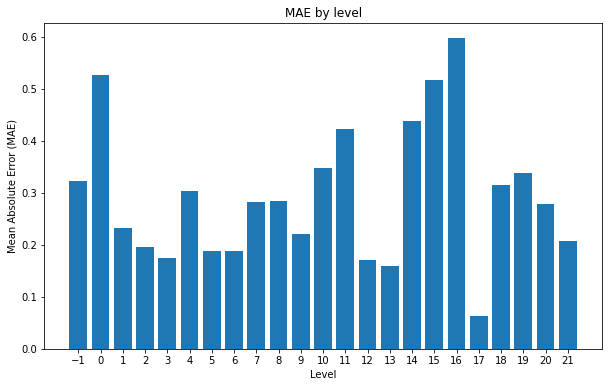

In [71]:
plot_mae_by_level(y_test_random_split, y_pred_test)

In [72]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.04
RMSE: 0.19

Round type: round
MSE: 0.04
RMSE: 0.21

Round type: 0.33
MSE: 0.05
RMSE: 0.22

Round type: 0.45
MSE: 0.04
RMSE: 0.21



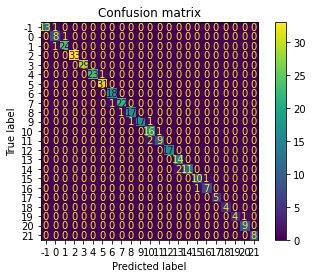

In [73]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [74]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,0.260866,0.510751,0.357177
1,chronological,Optuna,13,0.193395,0.439767,0.312398
2,random,normal,13,0.148111,0.384853,0.267273
3,random,Optuna,13,0.114576,0.338490,0.235578


In [75]:
from training.results import plot_summary

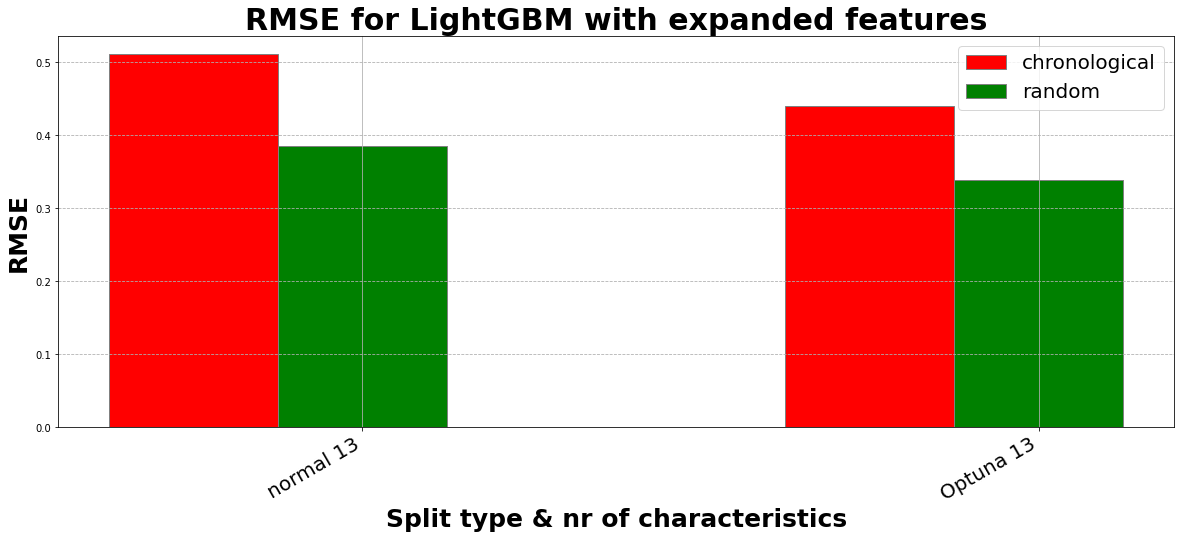

In [76]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

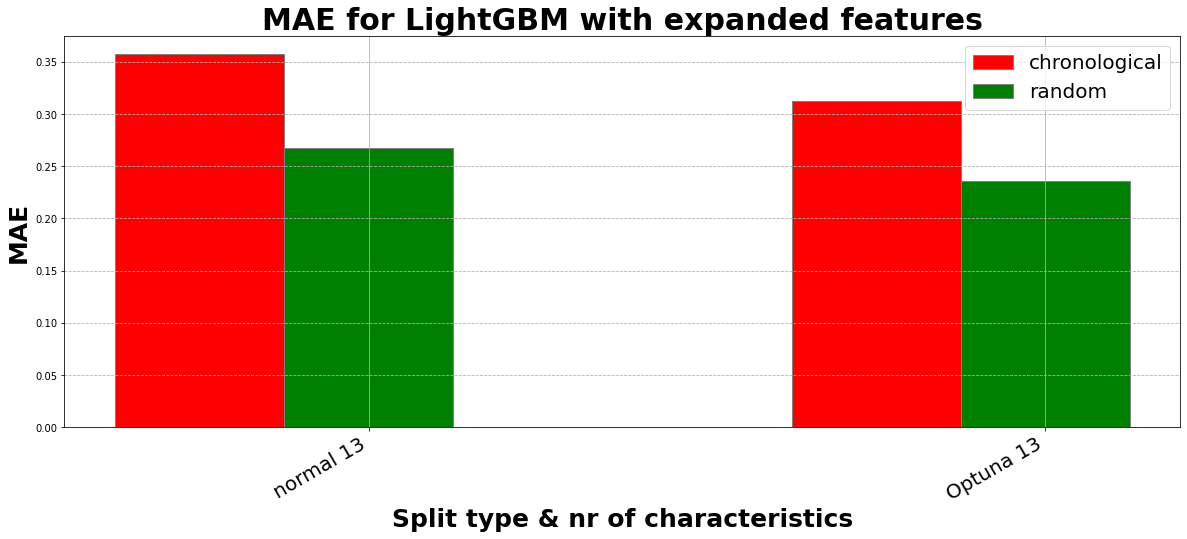

In [77]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [78]:
results.to_json("./lightgbm_second_results.json")